In [1]:
!pip install keras tqdm

In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import keras.backend as K
from keras.layers import Activation, Input

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')


Using TensorFlow backend.


### Loading data (Olivetti faces)

In [0]:
data_obj = fetch_olivetti_faces()

X_original = data_obj['data']

#binarize data
X = 1.0 * (X_original > X_original.mean())

y = data_obj['target']

indices = np.arange(len(y))

indices_train, indices_test, y_train, y_test = train_test_split(indices, y, stratify=y, test_size=0.1, random_state=0)

X_train = X[indices_train]
X_test = X[indices_test]

### RBM definitions

RBMs are undirected graphical models with the following structure ($h_i, v_j$ are binary):

<p align="center"><img src="http://40.media.tumblr.com/5e4a23b85f61e2aaeeb1188c2e35536a/tumblr_inline_npz2ev1m5Y1rnd3q0_540.png" /></p>

The joint probability is given by:
$$E(v, h) = vWh$$

$$P(v, h) = \frac{e^{-E(v, h)}}{Z}$$

($Z$ is a normalizing factor, $Z = \sum_{u, g}e^{-E(u, g)}$)

That means that $$P(h|v) = \prod_{i}P(h_i|v)$$ and consequently from the definition it follows that $$P(h_i = 1 \mid v) = \frac{1}{1 + exp((vW)_{i})}$$

RBMs are optimized using approximation to likelihood.

$$P(x) = \frac{\sum_{h}P(x, h)}{Z}$$

The algorithm that is used to approximate derivatives of log likelihood is called **contrastive divergence**, see for example [this link](http://deeplearning.net/tutorial/rbm.html).

In [0]:
def probabilities_from_other(W, other):
  """
  Get probabilities from hidden given visible or the other way around
  """
  energy = K.dot(other, W)
  return K.sigmoid(energy)


def sample_bernoulli(probas):
  uniform_samples = K.random_uniform(shape=K.shape(probas))
  bernoulli_samples = K.greater(
    probas,
    uniform_samples
  )
  return K.cast(bernoulli_samples, K.floatx())


def sample_from_other(W, other):
  """
  Sample hidden given visible or the other way around
  """
  proba = probabilities_from_other(W, other)
  return sample_bernoulli(proba)


def free_energy(W, visible):
  return - K.sum(
    K.softplus(K.dot(visible, W)),
    axis=-1
  )


def cd1_variables(W, visible):
  hidden0 = K.identity(
      probabilities_from_other(W, visible),
      name='hidden0')
  
  # suggested at Hinton's course - don't sample, use probabilities
  visible1 = K.identity(
      probabilities_from_other(K.transpose(W), hidden0),
      name='visible1')
  
  return hidden0, visible1


def cd1(W, visible):
  hidden0, visible1 = cd1_variables(W, visible)
  goodness0 = free_energy(W, visible)
  
  # we do this not to mess up gradient computation
  visible1_correct = K.stop_gradient(visible1)
  goodness1 = free_energy(W, visible1_correct)
  
  return K.mean(goodness0 - goodness1)

### Gradient descent methods

In [0]:
def gradient_descent_updates(loss, weights, lr):
  grads = K.gradients(loss, weights)
  return [K.update(weights, weights - lr * grad) for grad in grads]


def momentum_updates(loss, weights, lr, beta):
  grads = K.gradients(loss, weights)
  momentums = [K.variable(np.zeros(weights.shape)) for grad in grads]
  momentum_updates = [
      K.update(momentum, beta * momentum + grad)
      for (momentum, grad) in zip(momentums, grads)
  ]
  weight_updates = [
      K.update(weights, weights - lr * momentum)
      for momentum in momentums
  ]
  return momentum_updates + weight_updates



### RBM class

In [0]:
class RBM:
  
  DEFAULT_LOG_N_EPOCHS = 100
  
  def __init__(self, n_visible, n_hidden):
    self.n_visible = n_visible
    self.n_hidden = n_hidden
    init_std = np.sqrt(n_hidden)
    self.W_in = K.variable(
        np.random.uniform(size=(n_visible, n_hidden), low=-2 / init_std, high= 2 / init_std)
    )
    self.visible_in = Input(shape=(n_visible,))
    self.cd = cd1(self.W_in, self.visible_in)
    
  
  def fit(
      self,
      X_train,
      n_epochs,
      learning_rate=2e-3,
      weight_decay=1e-3,
      minibatch_size=16,
      log_n_epochs=None):

    if log_n_epochs is None:
      self.log_n_epochs = RBM.DEFAULT_LOG_N_EPOCHS
    
    loss = self.cd + weight_decay * K.sum(self.W_in ** 2)
    [cd1_gradient] = K.gradients(loss, self.W_in)

    train_op = K.function(
        inputs=[self.visible_in],
        outputs=[self.cd, loss],
        updates=momentum_updates(loss, self.W_in, learning_rate, beta=0.9)
    )
    
    _n_batches = int(round(X_train.shape[0] / minibatch_size))
    
    return self._train(X_train, train_op, n_epochs, minibatch_size, self.log_n_epochs)
        
  def _train(self, X_train, train_op, n_epochs, minibatch_size, log_n_epochs):
    
    self.batches_per_epoch = int(round(X_train.shape[0] / minibatch_size))

    cd_values = []
    loss_values = []
    
    for epoch in range(n_epochs):
      for i in range(self.batches_per_epoch):
        minibatch_indices = np.random.randint(X_train.shape[0], size=minibatch_size)
        minibatch = X_train[minibatch_indices]
        [cd_value, loss_value] = train_op([minibatch])
        cd_values.append(cd_value)
        loss_values.append(loss_value)
      if epoch % log_n_epochs == 0:
        last_loss_mean = np.mean(loss_values[-log_n_epochs:])
        last_cd_mean = np.mean(cd_values[-log_n_epochs:])

        print("epoch {}: cd={:.2f} loss={:.2f}".format(
            epoch,
            last_cd_mean,
            last_loss_mean)
        )
    return cd_values, loss_values
  

  def plot_history(self, cd_values, alpha=0.1):
    plt.title('Contrastive divergence')
    plt.plot(cd_values, label='cd')
    plt.plot(pd.Series(cd_values).ewm(alpha=alpha).mean(), label='smoothed cd')
    plt.xlabel('epoch')
    plt.ylabel('cd')
    plt.legend()
    plt.xticks(
        np.arange(0,
                  len(cd_values),
                  step=self.batches_per_epoch * self.log_n_epochs))
    plt.show()

#### Plotting utils

In [0]:
def show_reconstruction(original, reconstructed, reconstructed_probabilities, howmany=5):
  original_faces = original.reshape(-1, 64, 64)
  reconstructed_faces = reconstructed.reshape(-1, 64, 64)
  reconstructed_probabilities_faces = reconstructed_probabilities.reshape(-1, 64, 64)
  
  for i in range(howmany):
    test_face = original_faces[i]
    reconstructed_face = reconstructed_faces[i]
    reconstructed_proba_face = reconstructed_probabilities_faces[i]
    
    plt.subplot(331)
    plt.imshow(reconstructed_proba_face, cmap='gray')
    plt.title('probabilities')
    plt.axis('off')
    
    plt.subplot(332)
    plt.imshow(test_face, cmap='gray')
    plt.title('original binarized')
    plt.axis('off')
    
    plt.subplot(333)
    plt.imshow(reconstructed_face, cmap='gray')
    plt.title('reconstructed binarized')
    plt.axis('off')
    
    plt.show()
    
    
def plot_tiled(images):
  side_length = 10
  tiled_faces = np.vstack(
    [
        np.hstack(list(images[i*side_length:(i+1)*side_length].reshape(-1, 64, 64)))
        for i in range(side_length)
    ]
  )

  plt.figure(figsize=(16, 10))
  plt.title("""{} 'hidden' faces""".format(side_length **2))
  plt.imshow(tiled_faces, cmap='gray')
  plt.axis('off')
  plt.show()

### RBM setup

In [0]:
rbm = RBM(n_visible=X_train.shape[1], n_hidden=100)

In [9]:
print(K.eval(rbm.W_in))

[[ 0.0195254   0.08607575  0.04110535 ... -0.19195698  0.13157602
  -0.19812182]
 [ 0.07112662 -0.09199681  0.09407761 ... -0.09825741 -0.17678833
  -0.02623335]
 [-0.07528165  0.0785374  -0.04889926 ...  0.14487661  0.1891678
   0.18433386]
 ...
 [ 0.16334818 -0.14801535  0.0899542  ...  0.00966654  0.15546101
   0.0737697 ]
 [ 0.11428434 -0.18228921  0.19023965 ...  0.04311845  0.13657245
  -0.01176015]
 [-0.0366453  -0.17835753  0.07513931 ... -0.07539813 -0.14805831
   0.02060082]]


#### Run training

In [10]:
cd_values, loss_values = rbm.fit(X_train, 500)

epoch 0: cd=31.60 loss=37.10
epoch 100: cd=-249.69 loss=-225.77
epoch 200: cd=-263.78 loss=-221.46
epoch 300: cd=-263.64 loss=-205.96
epoch 400: cd=-261.66 loss=-191.33


### Plot training loss

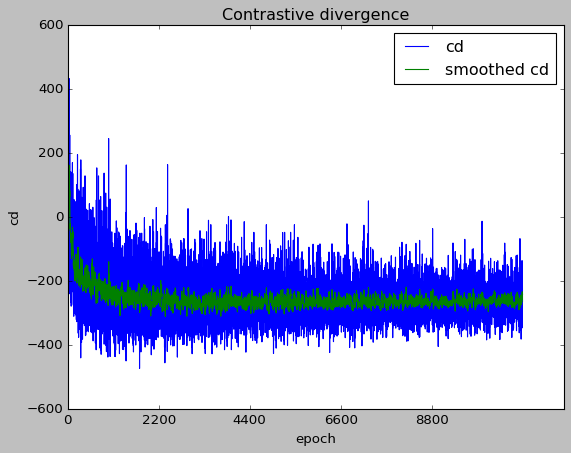

In [11]:
rbm.plot_history(cd_values)

In [12]:
print(K.eval(rbm.W_in))

[[-0.05215707  0.18594635 -0.0383114  ... -0.6321982   0.615998
  -0.6298999 ]
 [ 0.0203422  -0.09298855  0.03457535 ... -0.33553618 -0.00603592
  -0.69425124]
 [-0.03274693 -0.26159286 -0.01634568 ...  0.09097299 -0.08943809
  -0.40219647]
 ...
 [ 0.09341081 -0.16888331  0.04649358 ... -0.3991478   0.23662709
   0.61713403]
 [ 0.04490596 -0.11072622  0.09404474 ... -0.37906477  0.61899304
   0.6625217 ]
 [-0.05615374 -0.04133832  0.01590165 ... -0.3665562   0.3640379
   0.6593465 ]]


In [0]:
sample_hidden_from_visible = K.function(
  inputs=[rbm.visible_in],
  outputs=[
    probabilities_from_other(rbm.W_in, rbm.visible_in),
    sample_from_other(rbm.W_in, rbm.visible_in)
  ]
)

hidden_input = Input(shape=(rbm.n_hidden,))
sample_visible_from_hidden = K.function(
  inputs=[hidden_input],
  outputs=[
    probabilities_from_other(K.transpose(rbm.W_in), hidden_input),
    sample_from_other(K.transpose(rbm.W_in), hidden_input)]
)

In [0]:
[probabilities_visible_test, sampled_visible_test] = sample_visible_from_hidden(sample_hidden_from_visible([X_test]))
[probabilities_visible_train, sampled_visible_train] = sample_visible_from_hidden(sample_hidden_from_visible([X_train]))

### Show reconstructed faces

#### Reconstructed train faces

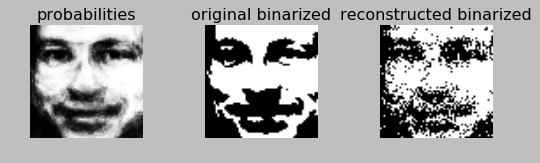

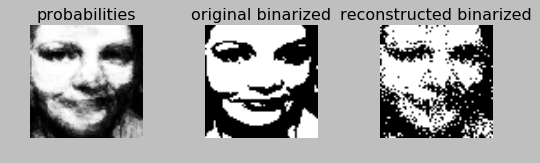

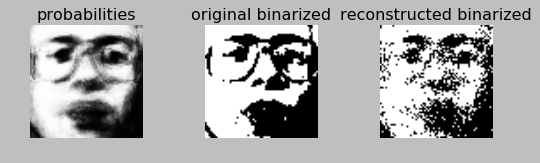

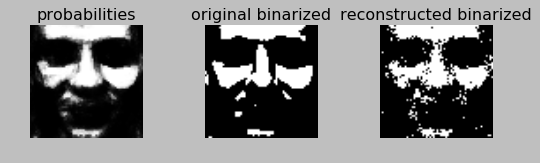

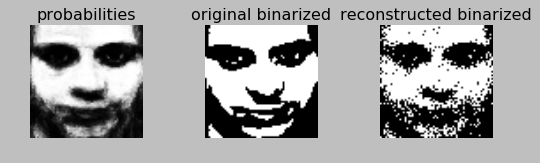

In [15]:
show_reconstruction(
    X_train,
    sampled_visible_train,
    probabilities_visible_train)

#### Reconstructed test faces

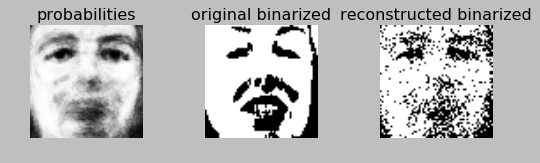

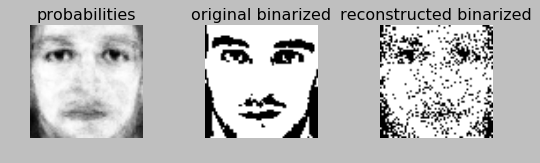

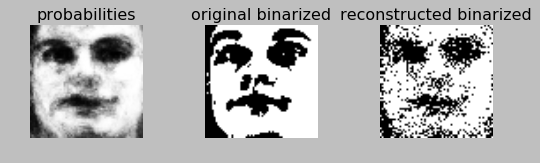

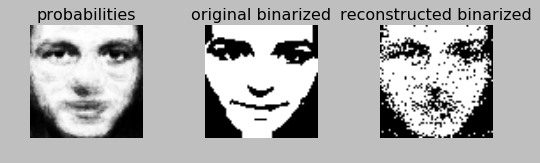

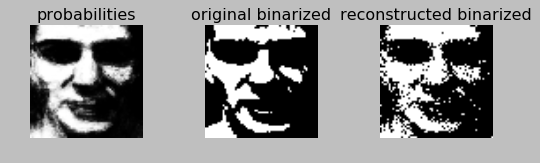

In [16]:
show_reconstruction(X_test, sampled_visible_test, probabilities_visible_test)

### Visualizing weights

Let's plot $P(v|h_i)$ for 100 $i$.

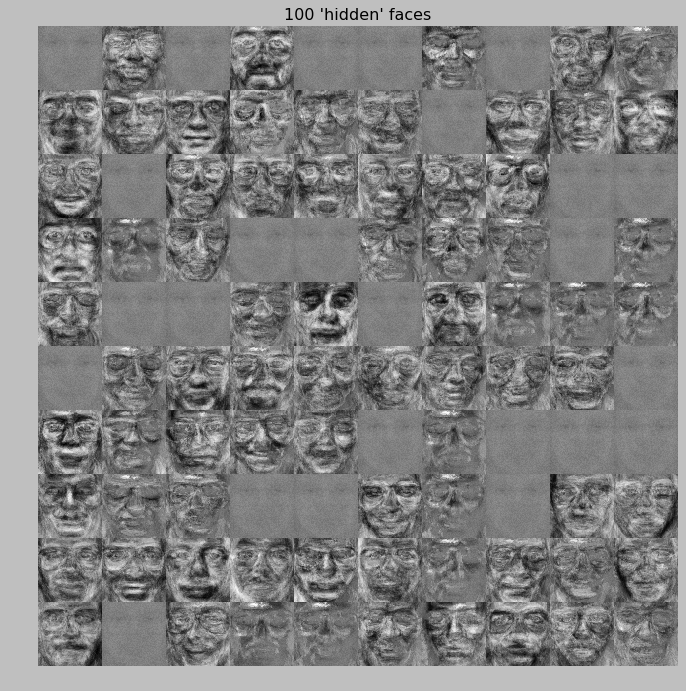

In [17]:
visible_probabilities_from_hidden = probabilities_from_other(
    K.transpose(rbm.W_in),
    hidden_input)

hidden_faces = visible_probabilities_from_hidden.eval(
    feed_dict={hidden_input: np.eye(rbm.n_hidden)},
    session=K.get_session()
)

plot_tiled(hidden_faces)